In [2]:
import pandas as pd
from data_prep import read_data
from data_analysis.analytics import vol_cal, fit_to_har, test_sig_up, fit_garch_on_innovations, fit_ar_on_har_residuals, forecast_test_har_ar
from data_analysis.plots import plot_log_returns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
data = read_data("binance_data/")

Elapsed time: 7852.621 seconds


In [4]:
# Vectorised log returns (faster & cleaner)
data["log_return"] = np.log(data["close"]).diff()
data = vol_cal(data, window=5)
data = vol_cal(data, window=60)
data = vol_cal(data, window=1440)
print(data['log_return'].describe())

count    4.412544e+06
mean     6.894854e-07
std      1.149050e-03
min     -7.510582e-02
25%     -3.344548e-04
50%      0.000000e+00
75%      3.353473e-04
max      7.229275e-02
Name: log_return, dtype: float64


In [5]:
print(data['rv_5m_ann'].describe())

count    4.412540e+06
mean     5.411367e-01
std      6.333458e-01
min      0.000000e+00
25%      2.191024e-01
50%      3.714982e-01
75%      6.333433e-01
max      4.544996e+01
Name: rv_5m_ann, dtype: float64


In [6]:
print(data['log_rv_5m_ann'].describe())

count    4.412540e+06
mean    -1.007873e+00
std      9.846214e-01
min     -1.842068e+01
25%     -1.518216e+00
50%     -9.902113e-01
75%     -4.567426e-01
max      3.816612e+00
Name: log_rv_5m_ann, dtype: float64


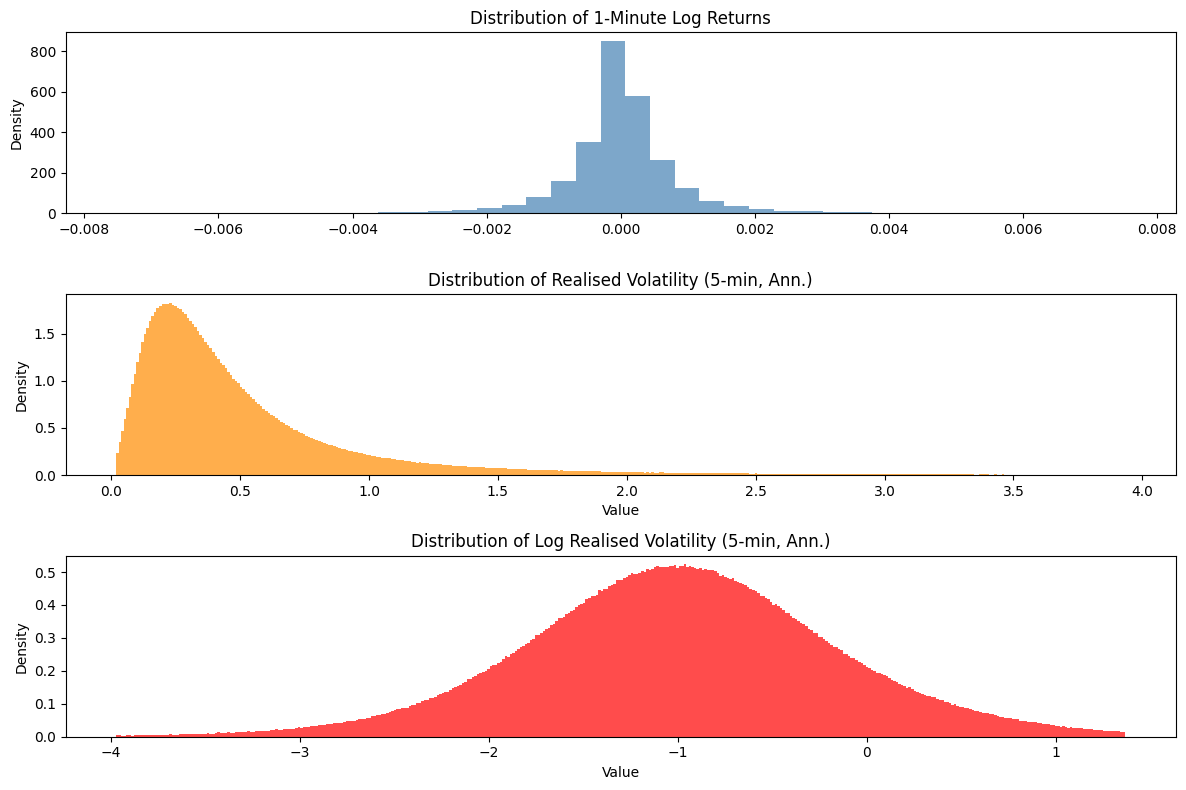

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=False)

# ---------- Panel 1: Log returns ----------
log_ret = data["log_return"].dropna().values

axes[0].hist(
    log_ret,
    bins=400,
    density=True,
    alpha=0.7,
    color="steelblue"
)

axes[0].set_title("Distribution of 1-Minute Log Returns")
axes[0].set_ylabel("Density")
axes[0].set_xlim(np.percentile(log_ret, 0.1), np.percentile(log_ret, 99.9))

# ---------- Panel 2: Realised volatility ----------
rv = data["rv_5m_ann"].dropna().values

# clip only for visual clarity (NOT analysis)
lo, hi = np.percentile(rv, [0.5, 99.5])
rv_plot = rv[(rv >= lo) & (rv <= hi)]
axes[1].hist(
    rv_plot,
    bins=400,
    density=True,
    alpha=0.7,
    color="darkorange"
)

axes[1].set_title("Distribution of Realised Volatility (5-min, Ann.)")
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Density")

# ---------- Panel 2: Log realised volatility ----------
log_rv = data["log_rv_5m_ann"].dropna().values

# clip only for visual clarity (NOT analysis)
lo, hi = np.percentile(log_rv, [0.5, 99.5])
log_rv_plot = log_rv[(log_rv >= lo) & (log_rv <= hi)]

axes[2].hist(
    log_rv_plot,
    bins=400,
    density=True,
    alpha=0.7,
    color="red"
)

axes[2].set_title("Distribution of Log Realised Volatility (5-min, Ann.)")
axes[2].set_xlabel("Value")
axes[2].set_ylabel("Density")

plt.tight_layout()
plt.show()

In [21]:
train_df, test_df, model = fit_to_har(data)
print(model.summary())
train_resid = train_df["log_target_rv"] - train_df["log_rv_hat"]

                            OLS Regression Results                            
Dep. Variable:          log_target_rv   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 1.159e+06
Date:                Mon, 02 Feb 2026   Prob (F-statistic):               0.00
Time:                        08:48:02   Log-Likelihood:            -3.6865e+06
No. Observations:             3528880   AIC:                         7.373e+06
Df Residuals:                 3528876   BIC:                         7.373e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.2196      0.001  

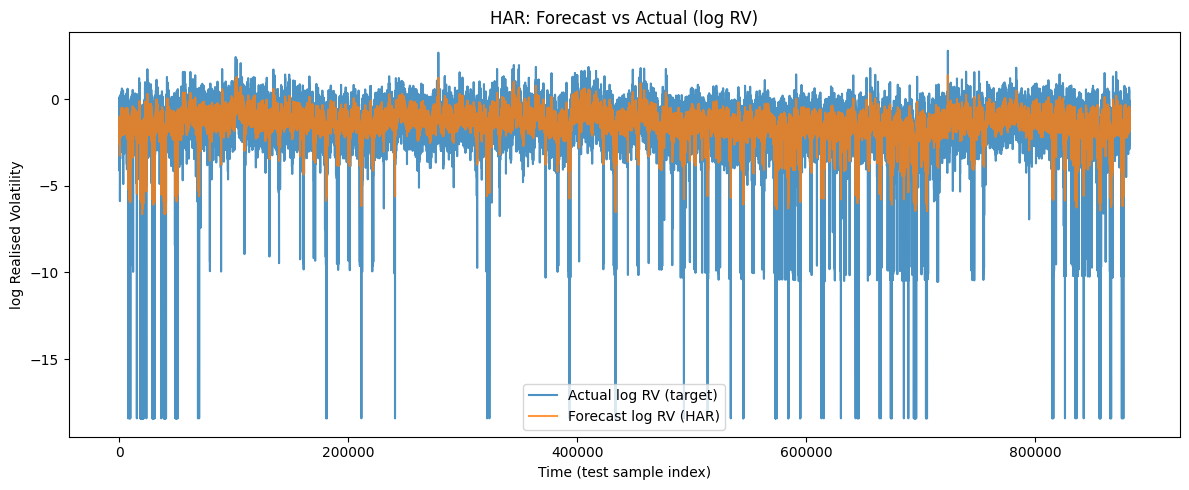

In [15]:
plt.figure(figsize=(12, 5))

# Plot of test set: forecast vs actual
t = np.arange(len(test_df))
plt.plot(t, test_df['log_target_rv'],   label="Actual log RV (target)", alpha=0.8)
plt.plot(t, test_df['log_rv_hat'],   label="Forecast log RV (HAR)", alpha=0.8)

plt.legend()
plt.title("HAR: Forecast vs Actual (log RV)")
plt.xlabel("Time (test sample index)")
plt.ylabel("log Realised Volatility")
plt.tight_layout()
plt.show()

In [17]:
har_rv_hat = np.exp(test_df['log_rv_hat'])
har_rv_real = np.exp(test_df['log_target_rv'])

har_rmse = np.sqrt(mean_squared_error(har_rv_hat, har_rv_real))
har_mae = mean_absolute_error(har_rv_real, har_rv_hat)
har_mse = mean_squared_error(har_rv_real, har_rv_hat)

# Relative errors
har_rel_rmse = har_rmse / np.mean(har_rv_real)
har_rel_mae = har_mae / np.mean(har_rv_real)
print(f"Out-of-sample RMSE: {har_rmse:.6f}", f"MAE: {har_mae:.6f}", f"MSE: {har_mse:.6f}")
print(f"Out-of-sample relative RMSE: {har_rel_rmse:.6f}", f"relative MAE: {har_rel_mae:.6f}")

Out-of-sample RMSE: 0.230028 MAE: 0.128427 MSE: 0.052913
Out-of-sample relative RMSE: 0.640813 relative MAE: 0.357771


In [9]:
# Compute and print ACF of residuals and squared residuals
acf_resid = acf(train_resid.dropna(), nlags=20)
acf_resid_sq = acf(train_resid**2, nlags=50, fft=True)

# 95% confidence band
T = len(train_resid)
conf = 1.96 / np.sqrt(T)
print("ACF (residuals) first 5 lags:", acf_resid[1:6])
print("ACF (squared residuals) first 5 lags:", acf_resid_sq[1:6])
print("95% conf band:", conf)

ACF (residuals) first 5 lags: [ 0.74133507  0.52327821  0.33042762  0.15235968 -0.01713792]
ACF (squared residuals) first 5 lags: [0.56675454 0.33505744 0.19977309 0.1197925  0.08928595]
95% conf band: 0.0010433682723185456


In [10]:
# 1) AR(1) on HAR residuals (train)
ar_res, train_ar_df = fit_ar_on_har_residuals(train_df, ar_order=1)

# 2) GARCH(1,1) on AR innovations (train)
garch_res = fit_garch_on_innovations(train_ar_df["innov"], p=1, q=1)

print(ar_res.summary())
print(garch_res.summary())

                               SARIMAX Results                                
Dep. Variable:              har_resid   No. Observations:              3528880
Model:                 ARIMA(1, 0, 0)   Log Likelihood            -2279213.461
Date:                Mon, 02 Feb 2026   AIC                        4558432.922
Time:                        02:18:09   BIC                        4558472.152
Sample:                             0   HQIC                       4558443.201
                            - 3528880                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.171e-09      0.001  -1.76e-06      1.000      -0.002       0.002
ar.L1          0.7413   4.89e-05   1.51e+04      0.000       0.741       0.741
sigma2         0.2131   1.42e-05    1.5e+04      0.0

In [11]:
# Forecast HAR + AR on test set
preds, actuals = forecast_test_har_ar(
    train_df,
    test_df,
    model,
    ar_res,
    short_col="log_rv_5m_ann",
    med_col="log_rv_60m_ann",
    long_col="log_rv_1440m_ann",
)

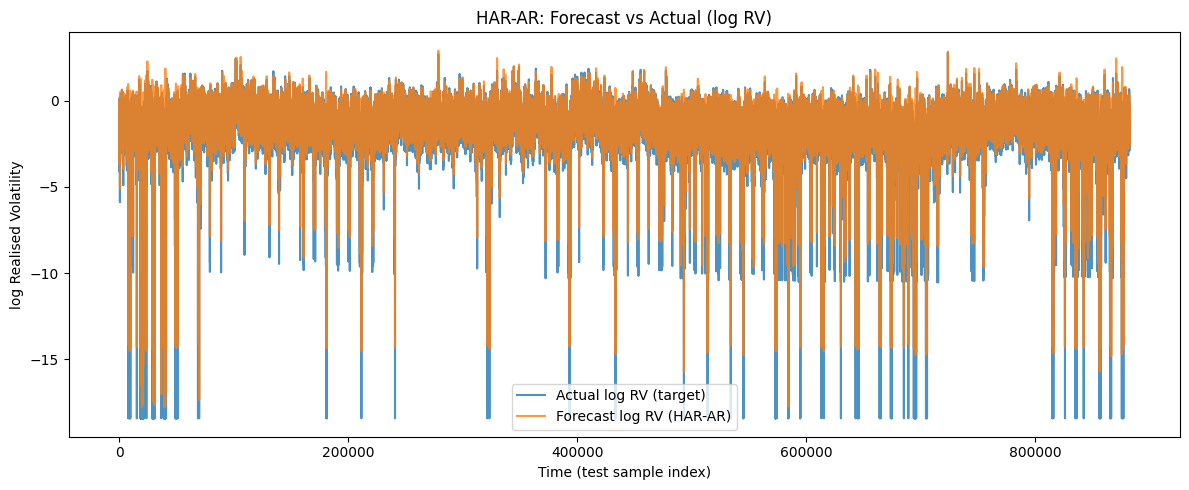

In [19]:
plt.figure(figsize=(12, 5))

t = np.arange(len(actuals))

# preds[i] and actuals[i] refer to the SAME target: log RV over (t_i, t_i+5]
plt.plot(t, actuals, label="Actual log RV (target)", alpha=0.8)
plt.plot(t, preds,   label="Forecast log RV (HAR-AR)", alpha=0.8)

plt.legend()
plt.title("HAR-AR: Forecast vs Actual (log RV)")
plt.xlabel("Time (test sample index)")
plt.ylabel("log Realised Volatility")
plt.tight_layout()
plt.show()

In [18]:
rv_hat = np.exp(preds)
rv_real = np.exp(actuals)

rmse = np.sqrt(mean_squared_error(rv_hat, rv_real))
mae = mean_absolute_error(rv_real, rv_hat)
mse = mean_squared_error(rv_real, rv_hat)

# Relative errors
rel_rmse = rmse / np.mean(rv_real)
rel_mae = mae / np.mean(rv_real)

print(f"Out-of-sample RMSE: {rmse:.6f}", f"MAE: {mae:.6f}", f"MSE: {mse:.6f}")
print(f"Out-of-sample relative RMSE: {rel_rmse:.6f}", f"relative MAE: {rel_mae:.6f}")

Out-of-sample RMSE: 0.139937 MAE: 0.072924 MSE: 0.019582
Out-of-sample relative RMSE: 0.389836 relative MAE: 0.203152
